# 2D Multi-element airfoil

Part 1: Williams' test case

In [199]:
import os
import numpy
import math
from scipy import integrate, linalg
from matplotlib import pyplot
%matplotlib inline

In [200]:
x_main, y_main = numpy.loadtxt("../AeroPython/lessons/resources/MainFoil_N=100.csv", dtype=float, delimiter=',', unpack=True)
x_flap, y_flap = numpy.loadtxt("../AeroPython/lessons/resources/FlapFoil_N=100.csv", dtype=float, delimiter=',', unpack=True)

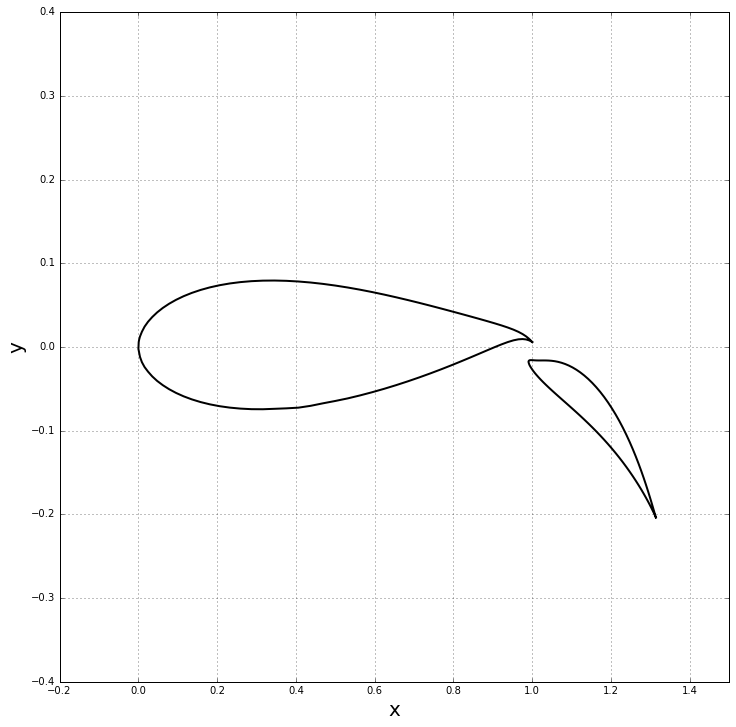

In [201]:
size = 12
pyplot.figure(figsize=(size, size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=20)
pyplot.ylabel('y', fontsize=20)
pyplot.xlim(-0.2, 1.5)
pyplot.ylim(-0.4, 0.4);
pyplot.plot(x_main, y_main, color='k', linestyle='-', linewidth=2)
pyplot.plot(x_flap, y_flap, color='k', linestyle='-', linewidth=2)



In [202]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center-point, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is located on the upper or lower surface of the geometry.
        Initializes the source-strength, tangential velocity, and pressure coefficient
        of the panel to zero.
        
        Parameters
        ---------_
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya # panel starting-point
        self.xb, self.yb = xb, yb # panel ending-point
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # panel center
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2) # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper' # upper surface
        else:
            self.loc = 'lower' # lower surface
        
        self.sigma = 0.0 # source strength
        self.vt = 0.0    # tangential velocity
        self.cp = 0.0    # pressure coefficient

In [203]:
def define_panels(x, y, N):
    """Discretizes the geometry into panels using input arrays for the ends of the panels.
    
    Arguments
    ---------
    x, y -- Cartesian coordinates of the panel endpoints.
    N - number of panels.
    
    Returns
    -------
    panels -- Numpy array of panels.
    """
    x_ends, y_ends = x, y
    panels = numpy.empty(N, dtype=object)
    
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
    return panels

N = 100

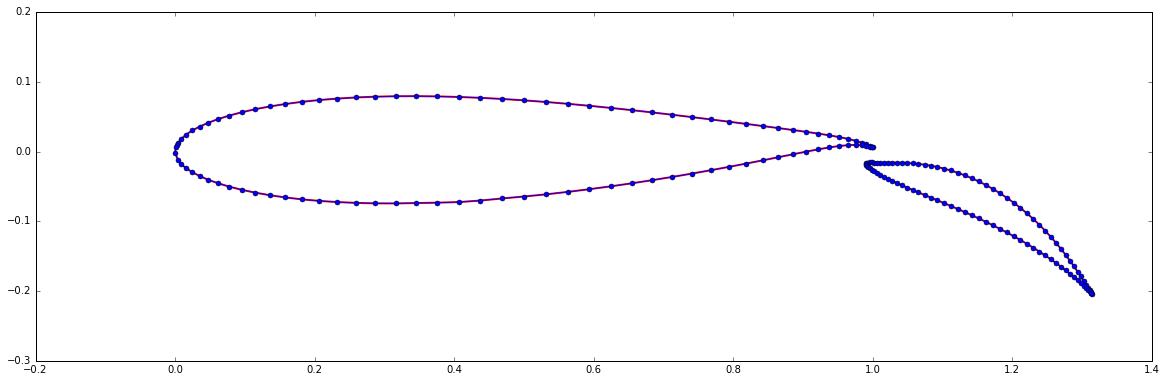

In [204]:
N = 100
panel_main, panel_flap = define_panels(x_main, y_main, N), define_panels(x_flap, y_flap, N)

size = 20
pyplot.figure(figsize=(size, size))
pyplot.plot(x_main, y_main, x_flap, y_flap, color='r', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.ylim(-0.3, 0.2)
pyplot.xlim(-0.2, 1.4)
pyplot.plot([panel.xa for panel in panel_main], [panel.ya for panel in panel_main], color='b', marker='o', markersize=5);
pyplot.plot([panel.xa for panel in panel_flap], [panel.ya for panel in panel_flap], color='b', marker='o', markersize=5);

In [205]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (in degrees).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default 0.0.
        """
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # degrees to radians

In [206]:
# define freestream conditions
freestream = Freestream(u_inf=1.0, alpha=0.0)

In [207]:
def integral(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from the panel at a given point (x, y).
    """
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [208]:
def vortex_contribution_normal(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A

In [209]:
def source_contribution_normal(panels):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Source contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                numpy.cos(panel_i.beta),
                                                numpy.sin(panel_i.beta))
    return A

In [210]:
panels=numpy.empty(N*2, dtype=object)
for i in range(N*2):
    if i<N:
        panels[i]=panel_main[i]
    elif i>=N:
        panels[i]=panel_flap[i-N]

In [211]:
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)

In [212]:
def kutta_condition(A_source, B_vortex):
    """
    Builds the Kutta condition array.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    b: 1D Numpy array of floats
        The left-hand side of the Kutta-condition equation.
    """
    b= numpy.empty([2,A_source.shape[1]+2],dtype=float)
    
    b[0,:-2] = B_vortex[0, :] + B_vortex[N-1, :]
    b[1,:-2] = B_vortex[N, :] + B_vortex[2*N-1, :]
    
    b[-2,-2]=- numpy.sum(A_source[0,:N] + A_source[N-1,:N])
    b[-2,-1]=- numpy.sum(A_source[0,N:] + A_source[N-1,N:])
    
    b[-1,-2]=- numpy.sum(A_source[N,:N] + A_source[2*N-1,:N])
    b[-1,-1]=- numpy.sum(A_source[N,N:] + A_source[2*N-1,N:])
    return b

In [213]:
def build_singularity_matrix(A_source, B_vortex):
    """
    Builds the left-hand side matrix of the system
    arising from source and vortex contributions.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  2D Numpy array of floats
        Matrix of the linear system.
    """
    A = numpy.empty((A_source.shape[0]+2, A_source.shape[0]+2), dtype=float)
    A[:-2, :-2] = A_source
    A[:-2, -2] = numpy.sum(B_vortex[:,:N], axis=1)    
    A[:-2, -1] = numpy.sum(B_vortex[:,N:], axis=1)
    A[-2:, :] = kutta_condition(A_source, B_vortex)
    return A

In [214]:
def build_freestream_rhs(panels, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = numpy.empty(panels.size+2,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-2] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                               +numpy.sin(freestream.alpha-panels[N-1].beta) )
    
    b[-1] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[N].beta)
                               +numpy.sin(freestream.alpha-panels[2*N-1].beta) )
    return b

In [215]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)

In [216]:
# solve for singularity strengths
strengths = numpy.linalg.solve(A, b)

# store source strength on each panel
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
    
# store circulation density
gamma_main = strengths[-2]
gamma_flap = strengths[-1]

In [217]:
def compute_tangential_velocity(panels, freestream, gamma_main, gamma_flap, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = numpy.empty((panels.size, panels.size+2), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-2] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -2] = -numpy.sum(A_source[:,:N], axis=1)
    A[:, -1] = -numpy.sum(A_source[:,N:], axis=1)
    # freestream contribution
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    strengths = numpy.append([panel.sigma for panel in panels], gamma_main)
    strengths = numpy.append(strengths,gamma_flap)
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [218]:
# tangential velocity at each panel center.
compute_tangential_velocity(panels, freestream, gamma_main, gamma_flap, A_source, B_vortex)

In [219]:
def compute_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [220]:
# surface pressure coefficient
compute_pressure_coefficient(panels, freestream)

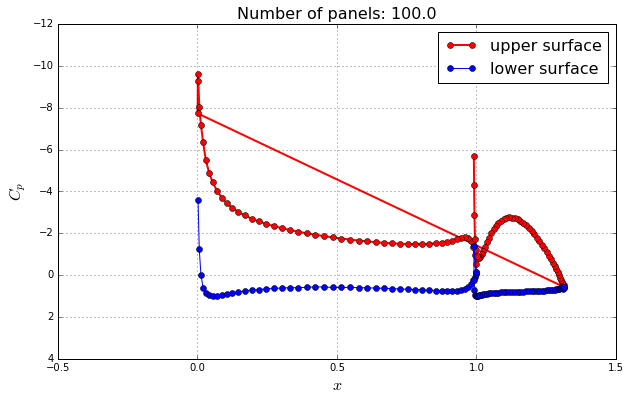

In [222]:
# plot surface pressure coefficient
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-0.5, 1.5)
pyplot.ylim(-12, 4.0)
pyplot.title('Number of panels: {}'.format(panels.size*0.5), fontsize=16);
pyplot.gca().invert_yaxis()

Question 1:

In [223]:

print('pressure coefficient on the $3$rd panel on the main airfoil is', panels[2].cp)

pressure coefficient on the $3$rd panel on the main airfoil is -0.955701172981


Question 2:

In [224]:
print('the pressure coefficient on the $10$th panel on the flap airfoil is', panels[109].cp)

the pressure coefficient on the $10$th panel on the flap airfoil is -0.279918398369


Question 3:

In [225]:
lift,drag = 0,0
for panel in panels:
    lift -= panel.cp*numpy.sin(panel.beta)*panel.length
    drag += panel.cp*numpy.cos(panel.beta)*panel.length

In [226]:
print('lift is', lift)

lift is 3.69771447686


Question 4:

In [227]:
print('drag is', drag)

drag is 0.0107914032459


Question 5:

In [228]:
lift_theoretical=3.7386
abe=abs(lift-lift_theoretical)
abe

0.040885523139250868

when N = 200, the lift is 3.71843390868 and the absolute error is 0.02.(in other file named assignment 3 200), so the improvment is about 50%.

# Part 2: Wenzinger's test case

In [289]:
def coordinate_rotate(point, theta, x, y): 
    theta2 = theta/180*numpy.pi
    x1, y1= 0,0
    x1, y1 = x - point[0]*numpy.ones_like(x), y - point[1]*numpy.ones_like(y)
    x2 = x1*numpy.cos(theta2) + y1*numpy.sin(theta2) + point[0]*numpy.ones_like(x)
    y2 = x1*(-1)*numpy.sin(theta2) + y1*numpy.cos(theta2) + point[1]*numpy.ones_like(y)   
    return x2, y2

In [230]:
x2_main, y2_main = numpy.loadtxt("../AeroPython/lessons/resources/NACA23012_MainFoil.csv", dtype=float, delimiter=',', unpack=True)
x2_flap, y2_flap = numpy.loadtxt("../AeroPython/lessons/resources/NACA23012_FlapFoil.csv", dtype=float, delimiter=',', unpack=True)

(-0.2, 0.2)

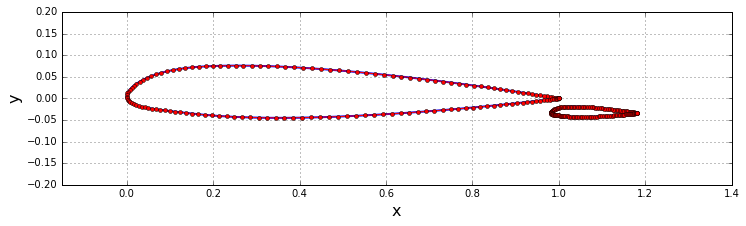

In [231]:
width = 12
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x2_main, y2_main, x2_flap, y2_flap, color='b', linestyle='-', linewidth=2)
pyplot.plot(x2_main, y2_main, color='r', marker='o', markersize=4)
pyplot.plot(x2_flap, y2_flap, color='r', marker='o', markersize=4)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.15, 1.4)
pyplot.ylim(-0.2, 0.2)

In [232]:
theta = 20
N = x2_main.size - 1
point = [1.03, -0.054]
x2_flap, y2_flap = coordinate_rotate(point, theta, x2_flap, y2_flap)

In [233]:
panels2_main = define_panels(x2_main, y2_main, N)
panels2_flap = define_panels(x2_flap, y2_flap, N)

(-0.2, 0.2)

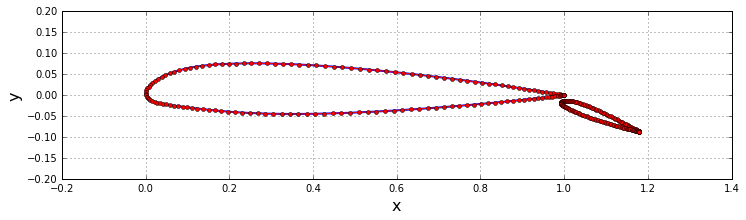

In [234]:
width = 12
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x2_main, y2_main, x2_flap, y2_flap, color='b', linestyle='-', linewidth=2)
pyplot.plot(x2_main, y2_main, color='r', marker='o', markersize=4)
pyplot.plot(x2_flap, y2_flap, color='r', marker='o', markersize=4)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.2, 1.4)
pyplot.ylim(-0.2, 0.2)

In [235]:
panels = numpy.empty(N*2, dtype=object)
for i in range(N*2):
    if i<N:
        panels[i]=panels2_main[i]
    elif i>=N:
        panels[i]=panels2_flap[i-N]

In [236]:
alpha_start, alpha_end = -14, 14
A_source=source_contribution_normal(panels)
B_vortex= vortex_contribution_normal(panels)
A = build_singularity_matrix(A_source, B_vortex)
B = build_freestream_rhs(panels, freestream)
strengths = numpy.linalg.solve(A, B)

In [251]:
def panel_lift(panels):
    N = panels.size

    L = 0
    for i in range(N-1):
        L -= panels[i].cp * panels[i].length * numpy.sin(panels[i].beta)        
    return L

In [247]:
def total_lift(aoa, aof):

    u_inf = 1.0
    freestream = Freestream(u_inf, aoa)

    for i , panel in enumerate(panels):
        panel.sigma = strengths[i]
        
    # store circulation density
    gamma_main = strengths[-2]
    gamma_flap = strengths[-1]
    
    # computes the tangential velocity and cp at each panel
    compute_tangential_velocity(panels, freestream, gamma_main, gamma_flap, A_source, B_vortex)
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2
        
    # calculates lift
    lift = panel_lift(panels)
    
    return lift

In [287]:
def bisection_aoa(a, b, aof, tol):
    Lift_a = total_lift(a, aof)
    Lift_b = total_lift(b, aof)
    print(Lift_a, Lift_b)
    while (Lift_b-Lift_a)/2.0 > tol:      #if the test range is ok
        c = (a+b)/2.0                     #pick the middle number as c
        Lift_a = total_lift(a, aof)       #get LIFT in a,b,c
        Lift_b = total_lift(b, aof)
        Lift_c = total_lift(c, aof)
        
        if numpy.abs(Lift_c) <= tol:      #to know if angle c is the answer
            
            print(c, Lift_c)
            
            
        elif Lift_a * Lift_c < 0:         #determine whether 0 is in range a to c or not
                print('wait')
                b = c
        else:
                print('wait')
                a = c

In [267]:
def bisection_aof(a,b,aoa,tol):
    Lift_a = total_lift(aoa, a)
    Lift_b = total_lift(aoa, b)
    
    while (Lift_b-Lift_a)/2.0 > tol:      #if the test range is ok
        c = (a+b)/2.0                     #pick the middle number as c
        Lift_a = total_lift(aoa, a)       #get LIFT in a,b,c
        Lift_b = total_lift(aoa, b)
        Lift_c = total_lift(aoa, c)
        
        if numpy.abs(Lift_c) <= tol:      #to know if angle c is the answer
            print(c, Lift_c)             
        elif Lift_a * Lift_c < 0:         #determine whether 0 is in range a to c or not
            b = c
        else:
            a = c
            
      

In [299]:
bisection_aoa(-14, 14, 20, 0.01)

NameError: name 'panels_main' is not defined

In [ ]:
bisection_aof(-10,10,0,0.001)

SyntaxError: invalid syntax (<ipython-input-242-ecd656e54ef7>, line 3)